In [22]:
!pip install lxml


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
!pip freeze > ..//requirements.txt

In [24]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.tsa.stattools import (adfuller, 
                                       acf, pacf)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import (mean_absolute_error, 
                             mean_squared_error, 
                             mean_absolute_percentage_error,
                             r2_score)
from sklearn.model_selection import TimeSeriesSplit

from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo

from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

# hyperparameters tuning
from hyperopt import STATUS_OK, STATUS_FAIL, Trials, fmin, hp, tpe, space_eval

from hyperopt import space_eval


In [25]:

df = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view', decimal=',', thousands='.', parse_dates=True)[2][1:]
df.columns=['Date','Preco']
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [26]:
df

Date  Preco
1     2023-12-18  78.89
2     2023-12-15  76.84
3     2023-12-14  77.05
4     2023-12-13  74.14
5     2023-12-12  74.11
...          ...    ...
11065 1987-05-26  18.63
11066 1987-05-25  18.60
11067 1987-05-22  18.55
11068 1987-05-21  18.45
11069 1987-05-20  18.63

[11069 rows x 2 columns]

# Grafico historico

In [27]:
len(df)

11069

In [28]:
min(df.Date), max(df.Date)

(Timestamp('1987-05-20 00:00:00'), Timestamp('2023-12-18 00:00:00'))

One way to test whether a time series is stationary is to perform an augmented Dickey-Fuller test, which uses the following null and alternative hypotheses:

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

HA: The time series is stationary.

In [29]:
# serie e estacionaria? ADF - augmented dick-fuller
adfuller(df['Preco'])

(-2.070943947125463,
 0.25635751276880414,
 31,
 11037,
 {'1%': -3.4309426267587546,
  '5%': -2.861801908484863,
  '10%': -2.5669094087621245},
 38694.48479642567)

Test statistic was -2.07094
P-value was 0.25

so, we fail to reject the null hypothesis - or, we dont have constant variance over time, since this time series is non-stationary

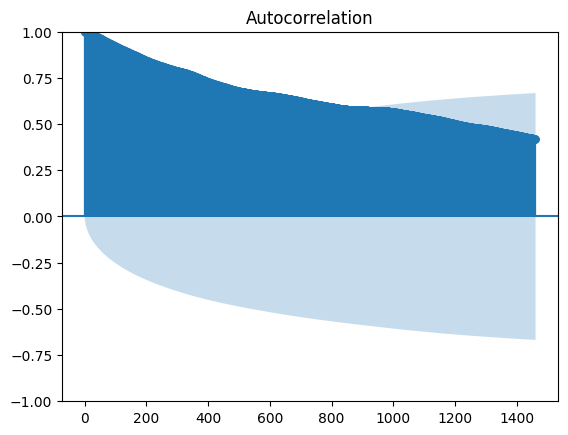

In [30]:
# ACF / PACF - autocorrelação e autocorrelação parcial 
# https://analyticsindiamag.com/what-are-autocorrelation-and-partial-autocorrelation-in-time-series-data/
acf_plot = plot_acf(df['Preco'], lags=1460)

In [31]:
acf(df['Preco'], nlags=1460)

array([1.        , 0.9989636 , 0.99817818, ..., 0.41951653, 0.41920068,
       0.4188754 ])

para a autocorrelação, vemos um comportamento significativo até aproximadamente 2 anos, ficando cada vez menos significativo a partir desse ponto... sera que tinhamos um comportamento diferente após esse tempo? o que disparou essa diferença no comportamento, a ponto de não ser estatisticamente significante a relação entre os valores atuais e de 2 anos anteriores?

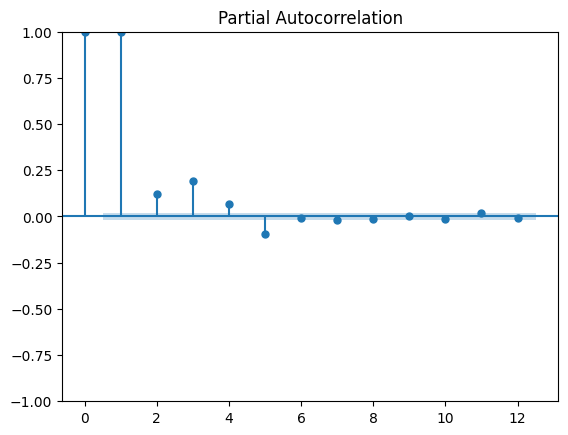

In [32]:
pacf_plot = plot_pacf(df['Preco'], lags=12)

os lags 0/1/2/3/4/5 possuem alguma correlaçao entre si, ficando cada vez menos forte a partir do 3, e especialmente fraca a partir do 6/7

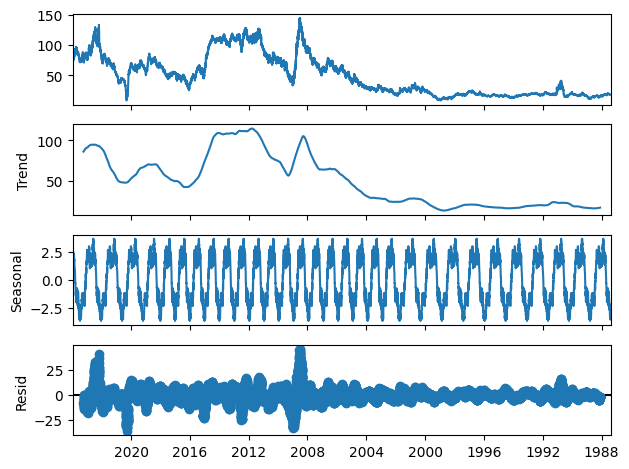

In [33]:
# componentes da serie
series = df[['Preco']]
series.index = pd.to_datetime(df.Date)
result = seasonal_decompose(series, model='additive', period=365)
result_plot = result.plot()


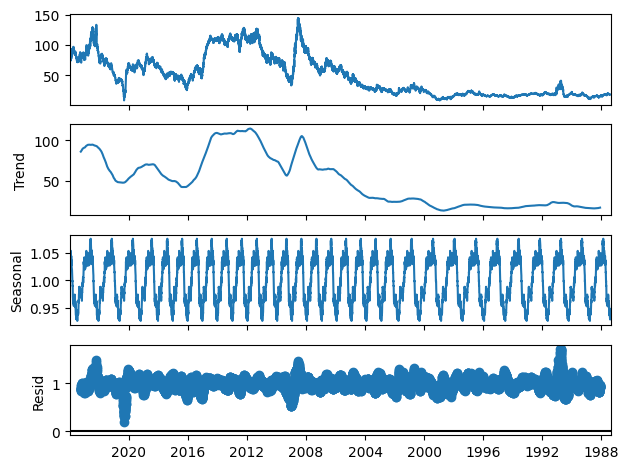

In [34]:
# componentes da serie - mult
series = df[['Preco']]
series.index = pd.to_datetime(df.Date)
result = seasonal_decompose(series, model='multiplicative', period=365)
result_plot = result.plot()


In [35]:
# normalização, como diferenciação, logaritmica ou com raízes

In [36]:
# previsao com arima
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalNaive, SeasonalWindowAverage
from sklearn.metrics import mean_absolute_percentage_error

df_ts = pd.DataFrame(df[['Date', 'Preco']].values, columns=['ds', 'y'])
df_ts['unique_id'] = 'PETR4'
df_ts['ds'] = pd.to_datetime(df_ts['ds'])
df_ts.sort_values('ds', inplace=True)

date_limit = '2023-01-01'

train = df_ts.loc[(df_ts['ds'] < date_limit) & (df_ts['ds'] >= '2022-01-01')]
test = df_ts.loc[df_ts['ds'] >= date_limit]
h = test.index.nunique()

model_all = StatsForecast(models=[
    SeasonalNaive(season_length=7),
    SeasonalWindowAverage(season_length=7, window_size=2),
    AutoARIMA(season_length=7)], freq='D', n_jobs=-1)

model_all.fit(train)

forecast_all = model_all.predict(h=h)
forecast_all = forecast_all.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast_all.dropna(inplace=True)

mape_seas_naive = mean_absolute_percentage_error(forecast_all['y'].values, forecast_all['SeasonalNaive'].values)
mape_seas_wa = mean_absolute_percentage_error(forecast_all['y'].values, forecast_all['SeasWA'].values)
mape_arima = mean_absolute_percentage_error(forecast_all['y'].values, forecast_all['AutoARIMA'].values)
graph = model_all.plot(train, forecast_all, unique_ids=['PETR4'], engine='plotly') 
print(f"seasonal naive={mape_seas_naive} | seasonal window average={mape_seas_wa} | auto arima={mape_arima}")
graph = graph.update_layout(
    autosize=False,
    width=1600,
    height=800,
)
graph

seasonal naive=0.05344284651785831 | seasonal window average=0.0523982301338685 | auto arima=0.055562302756663184


In [37]:
# Prophet puro
_model = Prophet()
_res = []

_df = df.reset_index(drop=True)[['Date','Preco']].rename(columns={'Date':'ds', 'Preco':'y'})

train_end = pd.to_datetime('2023-01-01')
X_train = _df.loc[_df.ds < train_end]
X_test = _df.loc[_df.ds >= train_end]

_model.fit(X_train)
forecast_ = _model.predict(X_train)
pred = _model.predict(X_test)
_df = pd.concat([_df, _model.predict(_df)])

_res.append({
    'n_splits':0,
    'test_size':len(X_test),
    'regressors':'',
    'train_index':0,
    'test_index':min(X_test.index),
    'max_date_train':max(X_train.ds),
    'max_date_test':max(X_test.ds),
    'test_mape':mean_absolute_percentage_error(X_test['y'].values, pred['yhat'].values),
    'all_series_mape':mean_absolute_percentage_error(X_train['y'].values, forecast_["yhat"].values)
})
_res

18:33:32 - cmdstanpy - INFO - Chain [1] start processing
18:33:35 - cmdstanpy - INFO - Chain [1] done processing


[{'n_splits': 0,
  'test_size': 243,
  'regressors': '',
  'train_index': 0,
  'test_index': 0,
  'max_date_train': Timestamp('2022-12-30 00:00:00'),
  'max_date_test': Timestamp('2023-12-18 00:00:00'),
  'test_mape': 0.09372396206562784,
  'all_series_mape': 1.615357967363726}]

In [38]:
plot_plotly(_model, forecast_)

In [39]:
plot_components_plotly(_model, forecast_)

In [40]:
# previsao com prophet + BCB como external variables

# Add external regressors
- focar em adicionar alguns dos datasets pra melhorar a previsao (com o prophet mesmo), e criar um slider pra aumentar/diminuir a média mensal de um ou dois fatores em x%

In [64]:
df = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view', decimal=',', thousands='.', parse_dates=True)[2][1:]
df.columns=['Date','Preco']
df.Date = pd.to_datetime(df.Date, dayfirst=True)

_df = df.reset_index(drop=True)[['Date','Preco']].rename(columns={'Date':'ds', 'Preco':'y'})

_df['ds'] = pd.to_datetime(_df['ds'])
_df = _df.reset_index()[['ds','y']]

_df = df.reset_index(drop=True)[['Date','Preco']].rename(columns={'Date':'ds', 'Preco':'y'})

train_end = pd.to_datetime('2023-01-01')
X_train = _df.loc[_df.ds < train_end].reset_index(drop=True)
X_test = _df.loc[_df.ds >= train_end]

In [24]:
global regressors
regressors=['RSI',
            'EMA_Short','EMA_Long','12MME','9MME','26MME','MACD','MACD_Signal_line','MACD_Histogram',
            'Standard_Deviation','Middle_Band','Upper_Band','Lower_Band'
            ]
# coluna Adj Close contem os valores reais no dia, close contem o dado do dia anterior;
# a coluna close com dado do dia anterior foi utilizada nos indicadores, pois eles fazem medias moveis incluindo o dado atual; dessa forma, evitamos o 'data leakage',
# ou, passar dados do presente/futuro para prever o presente
_df = df.dropna().reset_index(drop=True)[['Date','Close', 'Adj Close'] + regressors].rename(columns={'Date':'ds', 'Adj Close':'y'})

_df['ds'] = pd.to_datetime(_df['ds'])

train_end = pd.to_datetime('2023-01-01')
X_train = _df.loc[_df.ds < train_end].reset_index(drop=True)
X_test = _df.loc[_df.ds >= train_end].reset_index(drop=True)


In [25]:
# previsao com prophet
test_size=180

# definição da função objetivo a ser otimizada usando bayesian search (algoritmo tpe)
def objective(params):
   
    metrics, cv_mape = _run_cv_prophet(
                    df_model=X_train.dropna(),
                    params=params,
                    n_splits=5, test_size=test_size
                   )
    return {
                'loss':cv_mape
                , 'status': STATUS_OK
            }

space = {
    'yearly_seasonality':365
    , 'daily_seasonality':True
    , 'weekly_seasonality':True
    , 'seasonality_mode' : hp.choice('seasonality_mode', ['multiplicative','additive'])
    , "seasonality_prior_scale": hp.uniform("seasonality_prior_scale", 0.01, 10)
    , "changepoint_prior_scale": hp.uniform("changepoint_prior_scale", 0.001, 0.5)
    , "changepoint_range": hp.uniform("changepoint_range", 0.08, 0.95)
    , 'holidays_prior_scale' : hp.uniform('holidays_prior_scale', 0.01,10)
    , "regressors":''
    , "regressors": hp.choice("regressors", [[{"regressor_name": reg,
                                             "prior_scale": hp.uniform(reg + "_prior_scale", 0.01, 10),
                                             "mode": hp.choice(reg + "_mode", ['multiplicative','additive'])
                                             } for reg in regressors]])
}

trials = Trials() # see https://medium.com/doma/visualizing-hyperparameter-optimization-with-hyperopt-and-plotly-states-title-26369b020b5b
best = fmin(fn=objective, space=space, algo=tpe.suggest, trials=trials, max_evals=50, verbose=1)
_best_params = space_eval(space, best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [1:21:21<00:00, 97.64s/trial, best loss: 0.006313001895703212] 


In [26]:
print(_best_params)

hyper_model = Prophet(
    yearly_seasonality=_best_params["yearly_seasonality"],
    daily_seasonality=_best_params["daily_seasonality"],
    weekly_seasonality=_best_params["weekly_seasonality"],
    seasonality_mode=_best_params['seasonality_mode'],
    seasonality_prior_scale=_best_params['seasonality_prior_scale'],
    changepoint_prior_scale=_best_params["changepoint_prior_scale"],
    changepoint_range=_best_params["changepoint_range"],
    holidays_prior_scale=_best_params['holidays_prior_scale'])

for reg in _best_params["regressors"]:
    hyper_model.add_regressor(reg["regressor_name"], prior_scale=reg["prior_scale"], mode=reg["mode"])
    
hyper_model.add_country_holidays(country_name='BR')
        

hyper_model.fit(X_train)
pred = hyper_model.predict(X_test)
forecast_ = hyper_model.predict(_df)

print('-'*80)

test_y = X_test.loc[(X_test['ds'] >= train_end)]['y'].values
pred_yhat = pred.loc[(pd.to_datetime(pred['ds']) >= pd.to_datetime(train_end))]["yhat"].values
test_period_mape = mean_absolute_percentage_error(test_y, pred_yhat)
print('Test period MAPE:' + f'{round(test_period_mape * 100, 3)}'+'%')

all_series_mape = mean_absolute_percentage_error(_df['y'].values, forecast_['yhat'].values)
print('All series MAPE:' + f'{round(all_series_mape * 100, 3)}'+'%')

{'changepoint_prior_scale': 0.36986814614314123, 'changepoint_range': 0.9103358201137667, 'daily_seasonality': True, 'holidays_prior_scale': 9.916963284961007, 'regressors': ({'mode': 'additive', 'prior_scale': 8.720141045650621, 'regressor_name': 'RSI'}, {'mode': 'additive', 'prior_scale': 3.939308581077446, 'regressor_name': 'EMA_Short'}, {'mode': 'additive', 'prior_scale': 5.305407744630868, 'regressor_name': 'EMA_Long'}, {'mode': 'multiplicative', 'prior_scale': 5.15517877926408, 'regressor_name': '12MME'}, {'mode': 'multiplicative', 'prior_scale': 9.96463719476549, 'regressor_name': '9MME'}, {'mode': 'additive', 'prior_scale': 9.981760037063626, 'regressor_name': '26MME'}, {'mode': 'multiplicative', 'prior_scale': 8.42246687475398, 'regressor_name': 'MACD'}, {'mode': 'additive', 'prior_scale': 8.289420329153506, 'regressor_name': 'MACD_Signal_line'}, {'mode': 'additive', 'prior_scale': 8.138945179888596, 'regressor_name': 'MACD_Histogram'}, {'mode': 'multiplicative', 'prior_scale'

In [27]:
plot_plotly(hyper_model, forecast_)

In [28]:
import plotly.express as px
import plotly.graph_objs as go

fig = go.Figure()

df_validation = pd.merge(forecast_[['ds','yhat']], _df[['ds','y']])

fig.add_trace(go.Line(
    x=df_validation['ds'], y=df_validation['y'],
    name='Real'
))

fig.add_trace(go.Line(
    x=df_validation['ds'], y=df_validation['yhat'],
    name='Predito'
))
fig.update_layout(
        hovermode='x unified',
    )
fig.show()

## Validation

In [29]:
df_val = pd\
    .read_csv('../data/raw/dados_ibovespa_validation.csv')\
    .rename(columns={
          'Data':'Date'
        , 'Último':'Close'
        , 'Abertura':'Open'
        , 'Máxima':'High'
        , 'Mínima':'Low'
        , 'Vol.':'Volume'
    })
df_val['Adj Close'] =  df_val['Close']
df_val['Close'] = df_val.Close.shift(1)
df_val['Volume'] = df_val.Volume.shift(1)
df_val.Date = pd.to_datetime(df_val['Date']).dt.date
df_val = df_val.sort_values(['Date'])
df_val['Datetime'] = pd.to_datetime(df_val['Date'])
df_val.Open = df_val.Open.astype(float)
df_val.Close = df_val.Close.astype(float)
df_val.High = df_val.High.astype(float)
df_val.Low = df_val.Low.astype(float)
df_val.Volume = df_val.Volume.str.replace('M','000000').str.replace(',','').str.replace('K','000')
df_val.Volume = df_val.Volume.astype(float)
df_val['Base Volume'] = df_val.Volume.astype(float)
df_val = df_val.sort_values(['Datetime'])


from indicators import Indicators, generate_graph
indicators = Indicators(settings='')

df_val, crossovers, _, _, _, _, _, _, _, _ =  indicators.gen_all(df_val, 9999, macd_rsi_BB=False, rsi_window=14)

global regressors
regressors=['RSI',
            'EMA_Short','EMA_Long','12MME','9MME','26MME','MACD','MACD_Signal_line','MACD_Histogram',
            'Standard_Deviation','Middle_Band','Upper_Band','Lower_Band'
            ]

df_val = df_val.dropna().reset_index(drop=True)[['Date','Close','Adj Close'] + regressors].rename(columns={'Date':'ds', 'Adj Close':'y'})

df_val['ds'] = pd.to_datetime(df_val['ds'])

train_end = pd.to_datetime('2023-01-01')

In [30]:
validation_ = hyper_model.predict(df_val)

print('-'*80)

test_y = df_val.loc[(df_val['ds'] >= train_end)]['y'].values
pred_yhat = validation_.loc[(pd.to_datetime(validation_['ds']) >= pd.to_datetime(train_end))]['yhat'].values
test_period_mape = mean_absolute_percentage_error(test_y, pred_yhat)
print('Test period MAPE:' + f'{round(test_period_mape * 100, 3)}'+'%')

all_series_mape = mean_absolute_percentage_error(df_val['y'].values, validation_['yhat'].values)
print('All series MAPE:' + f'{round(all_series_mape * 100, 3)}'+'%')

--------------------------------------------------------------------------------
Test period MAPE:0.535%
All series MAPE:0.778%


In [31]:
import plotly.express as px
import plotly.graph_objs as go

fig = go.Figure()

df_validation = pd.merge(validation_[['ds','yhat']], df_val[['ds','y']])

fig.add_trace(go.Line(
    x=df_validation['ds'], y=df_validation['y'],
    name='Real'
))

fig.add_trace(go.Line(
    x=df_validation['ds'], y=df_validation['yhat'],
    name='Predito'
))
fig.update_layout(
        hovermode='x unified',
    )
fig.show()